In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="SimHei")
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

# 读取本地CSV文件（当前目录下的"14日留存预测特征数据导出.csv"）
df = pd.read_csv("data/14日留存预测特征数据导出.csv",low_memory=False)

print("数据加载成功！前5行:")
print(df.head(5))

# 检查关键字段是否存在
required_cols = ['first_login_date', 'is_retained_14d']  # 根据您的需求调整
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"⚠️ 警告：缺失关键字段: {missing_cols}")

numeric_cols = df.select_dtypes(include='number').columns
report = pd.DataFrame({
    '平均值': df[numeric_cols].mean(),
    '缺失数量': df[numeric_cols].isnull().sum(),
    '缺失比例(%)': (df[numeric_cols].isnull().mean() * 100).round(2)
})

# 新增：筛选平均值为0的字段
zero_mean_cols = report[report['平均值'] == 0]

if not zero_mean_cols.empty:
    print("\n=== 平均值为0的字段 ===")
    print(zero_mean_cols.sort_values('缺失比例(%)', ascending=False))
else:
    print("\n✅ 无平均值为0的字段")

# 原有完整报告（可选）
print("\n=== 完整数值字段报告 ===")
print(report.sort_values('缺失比例(%)', ascending=False))

数据加载成功！前5行:
                  rid first_login_date first_recharge_date  is_payer_first  \
0  R13114717046358351         2024/1/7                 NaN               0   
1  R13114717046351161         2024/1/7                 NaN               0   
2  R13114717046371743         2024/1/7                 NaN               0   
3  R13114717046374551         2024/1/7                 NaN               0   
4  R13114717046387721         2024/1/7                 NaN               0   

   days_to_first_pay  first_pay_bin  first_recharge_money  is_old_player  \
0               9999              0                     0              0   
1               9999              0                     0              1   
2               9999              0                     0              0   
3               9999              0                     0              0   
4               9999              0                     0              1   

   reg_is_workday  exp_get_7d  ...  wanansi_win_rate  war_fb_t

| 字段名称 | 用途描述 | 计算方式来源 (含原始表) | 业务意义 | 备注 |
|----------|----------|--------------------------|----------|------|
| rid | 角色 ID | `ga2_dwd_v2.dim_role.rid` | 主键 | |
| exp_get_7d | 经验总量 | `SUM(ga2_dwd_v2.fact_player_activity.exp_get)` | 成长快留存高 | 缺数据 |
| chengjiu_get_7d | 成就点总量 | `SUM(fact_player_activity.chengjiu_get)` | 目标完成度高更留存 | 缺数据 |
| yuanbao_get_7d | 元宝获得总量 | `SUM(fact_player_activity.yuanbao_get)` | 经济参与 | 缺数据 |
| yuanbao_cost_7d | 元宝消耗总量 | `SUM(fact_player_activity.yuanbao_cost)` | 消耗代表投入 | 缺数据 |
| copper_get_7d | 铜币获得总量 | `SUM(fact_player_activity.copper_get)` | 活跃产出 | 缺数据 |
| copper_cost_7d | 铜币消耗总量 | `SUM(fact_player_activity.copper_cost)` | 养成投入 | 缺数据 |
| yuanbao_spend_ratio | 元宝消耗率 | `yuanbao_cost_7d / yuanbao_get_7d` (源: `fact_player_activity`) | 囤积高可能易流失 | 缺数据 |
| copper_spend_ratio | 铜币消耗率 | `copper_cost_7d / copper_get_7d` (源: `fact_player_activity`) | 使用意愿体现 | 缺数据 |
| gumu_cnt_7d | 古墓次数 | `SUM(fact_player_activity.gumu_cnt)` | 探索参与 | 缺数据 |
| zhangmen_cnt_7d | 掌门挑战次数 | `SUM(fact_player_activity.zhangmen_cnt)` | 高难参与 | 缺数据 |
| leita_win_rate | 擂台胜率 | `胜 / 参赛` (源: `fact_player_activity_detail_sec.leitaibiwu_isWin`) | 胜率低易挫败 | 缺数据 |
| wanansi_win_rate | 爬塔胜率 | `胜 / 参赛` (源: `fact_player_activity_detail_sec.wanansi_isWin`) | 失败多易流失 | 缺数据 |
| max_wanansi_floor | 爬塔最高层 | `MAX(fact_player_activity_detail_sec.wanansi_floor)` | 深度进度 | 缺数据 |
| max_gumu_floor | 古墓最高层 | `MAX(fact_player_activity_detail_sec.gumu_floor)` | 深度进度 | 缺数据 |
| first_login_date | 注册日期 | `ga2_dwd_v2.dim_role.first_login_date` 转 DATE | 作为 7 天窗口起点 | |
| first_login_date | 首登时间 | `ga2_dwd_v2.dim_role.first_login_date` | 注册基准 | |
| first_recharge_date | 首充时间 | `ga2_dwd_v2.dim_role.first_recharge_date` | 付费时点 | |
| is_payer_first | 是否首充 | `dim_role.first_recharge_date IS NULL ? 0 : 1` | 付费玩家留存更高 | |
| days_to_first_pay | 首充间隔天数 | `datediff(dim_role.first_recharge_date, dim_role.first_login_date); 无首充 = 9999` | 首充越早留存越强 | |
| first_pay_bin | 首充分档 | `dim_role.first_recharge_money` 分箱 (0/1/2/3/4/5) | 付费层级影响留存 | |
| first_recharge_money | 首充金额 | `dim_role.first_recharge_money` NULL→0 | 金额越高留存越强 | |
| is_old_player | 是否老玩家 | `ga2_dwd_v2.dim_role.is_old_player` | 老玩家回流更稳 | |
| reg_is_workday | 注册日是否工作日 | `dim_role.first_login_date → dim_date.date_key → dim_date.is_workday` | 工作日 / 周末玩家差异 | |
| play_cnt_total_7d | 玩法总参与次数 | `SUM(各玩法 cnt, 源: fact_player_activity)` | 参与越多留存越高 | |
| play_type_cnt_7d | 玩法多样性 | `参与次数 > 0 的玩法种类数` (源: `fact_player_activity`) | 体验越广留存越稳 | |
| task_cnt_7d | 任务参与次数 | `SUM(fact_player_activity.task_cnt)` | 主线 / 任务推进 | |
| trunk_fb_cnt_7d | 主线副本次数 | `SUM(fact_player_activity.trunk_fb_cnt)` | 核心循环参与 | |
| biaoju_cnt_7d | 镖局次数 | `SUM(fact_player_activity.biaoju_cnt)` | 子玩法参与 | |
| boss_cnt_7d | Boss 次数 | `SUM(fact_player_activity.boss_cnt)` | 高难参与度 | |
| fish_cnt_7d | 钓鱼次数 | `SUM(fact_player_activity.fish_cnt)` | 休闲参与 | |
| haoling_cnt_7d | 号令次数 | `SUM(fact_player_activity.haoling_cnt)` | 活动参与 | |
| leitaibiwu_cnt_7d | 擂台次数 | `SUM(fact_player_activity.leitaibiwu_cnt)` | PVP 参与 | |
| paimai_cnt_7d | 拍卖次数 | `SUM(fact_player_activity.paimai_cnt)` | 交易参与 | |
| wanansi_cnt_7d | 爬塔次数 | `SUM(fact_player_activity.wanansi_cnt)` | 进度参与 | |
| war_fb_cnt_7d | 战争副本次数 | `SUM(fact_player_activity.war_fb_cnt)` | 副本参与 | |
| zhaomu_cnt_7d | 招募次数 | `SUM(fact_player_activity.zhaomu_cnt)` | 抽卡参与 | |
| total_7d_online_sec | 7 天在线时长 | `SUM(ga2_dwd_v2.fact_player_login_recharge.online_time_sec)` | 总投入强度 | |
| first3_online_sec | 前 3 天时长 | `SUM(day0-2 online_time_sec, 源: fact_player_login_recharge)` | 早期热度 | |
| last3_online_sec | 后 3 天时长 | `SUM(day4-6 online_time_sec, 源: fact_player_login_recharge)` | 近期活跃度 | |
| is_active_day7 | 第 7 天是否登录 | `day=6 是否有登录记录` (源: `fact_player_login_recharge`) | 强留存信号 | |
| activity_center_ratio | 活跃重心 | `last3_online_sec / total_7d_online_sec` | 后期活跃更易留存 | |
| last3_vs_first3 | 活跃趋势 | `last3_online_sec / first3_online_sec` | 升温或衰退判断 | |
| max_consecutive_days_7d | 最大连续登录天数 | `MAX(fact_player_login_recharge.continue_login_date_cnt)` | 习惯养成强 | |
| is_payer_7d | 7 天内是否付费 | `pay_amt_7d > 0` (源: `fact_player_login_recharge`) | 付费强信号 | |
| pay_amt_7d | 7 天充值金额 | `SUM(fact_player_login_recharge.real_money)` | 沉没成本 | |
| pay_cnt_7d | 7 天充值次数 | `SUM(fact_player_login_recharge.real_cnt)` | 付费习惯 | |
| pay_days_7d | 付费天数 | `COUNT(DISTINCT log_date WHERE real_money > 0)` | 持续付费更稳 | |
| avg_pay_per_txn | 平均单笔金额 | `pay_amt_7d / pay_cnt_7d` | 大额 / 小额结构 | |
| pay_trend_ratio | 后期付费占比 | `pay_last3_amt / pay_amt_7d` (源: `fact_player_login_recharge`) | 后期仍付费更稳 | |
| war_fb_through_rate | 副本通关率 | `通关 / 参战` (源: `fact_player_activity_detail_sec.war_fb_isThrough`) | 卡关风险 | |
| max_trunk_chapter | 主线最高章 | `MAX(fact_player_activity_detail_sec.trunk_fb_chapter)` | 主线进度 | |
| task_cnt_detail | 任务条目数 | `COUNT(fact_player_activity_detail_sec.task_status)` | 任务活跃 | |
| task_finish_cnt | 任务完成数 | `SUM(task_status=1, 源: fact_player_activity_detail_sec)` | 完成度 | |
| task_complete_rate | 任务完成率 | `task_finish_cnt / task_cnt_detail` | 顺畅度 | |
| task_finish_rate | 任务完成率（同上） | `task_finish_cnt / task_cnt_detail` | 任务完成度 | （注：与上一行重复，可合并） |

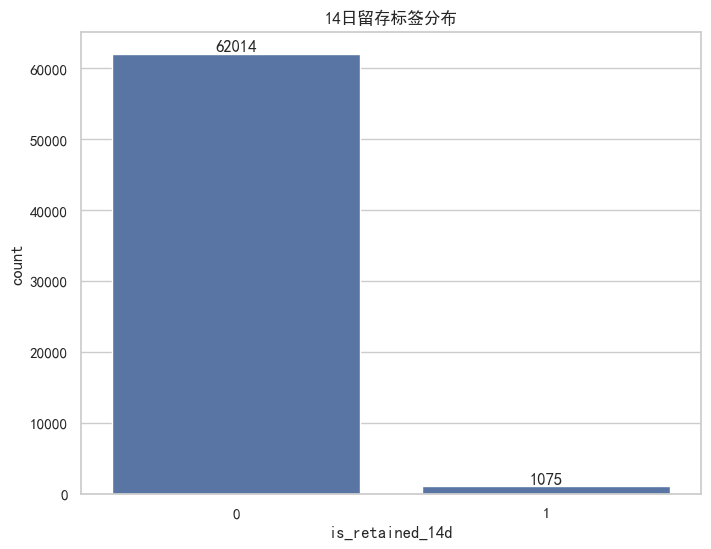

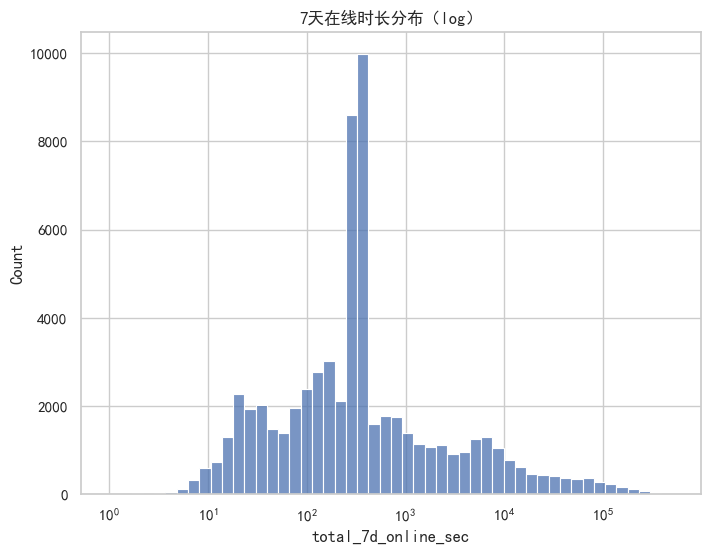

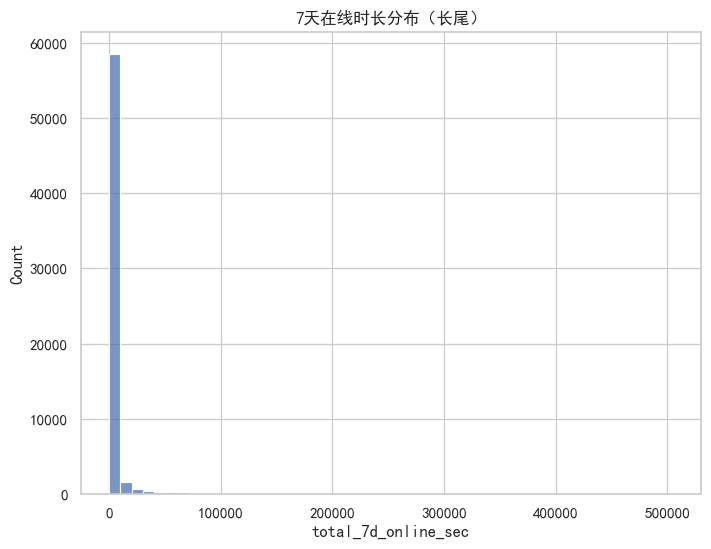

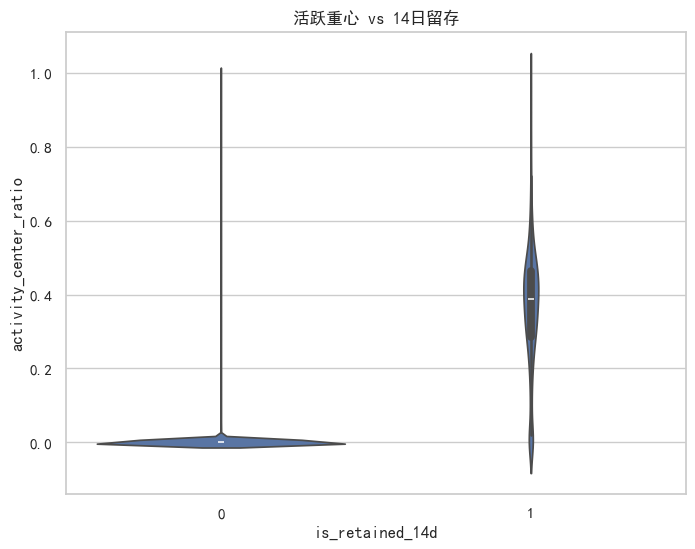

In [2]:


# 1) 留存标签分布
plt.figure(figsize=(8,6))
ax = sns.countplot(x='is_retained_14d', data=df)
plt.title('14日留存标签分布')

# 在每个柱子上添加具体数值
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # x坐标：柱子中心
        height + 50,                    # y坐标：柱子顶部上方50单位（根据数据量调整）
        f'{int(height)}',               # 显示整数格式
        ha='center',                    # 水平居中
        va='bottom'                     # 垂直对齐到文本底部
    )

plt.show()

# 2) 总在线时长分布（长尾）

plt.figure(figsize=(8,6))
sns.histplot(df['total_7d_online_sec'], bins=50, log_scale=True)
plt.title('7天在线时长分布（log）')
plt.show()
plt.figure(figsize=(8,6))
sns.histplot(df['total_7d_online_sec'], bins=50, log_scale=False)
plt.title('7天在线时长分布（长尾）')
plt.show()



# 3) 活跃重心 vs 留存（小提琴）
plt.figure(figsize=(8,6))
sns.violinplot(x='is_retained_14d', y='activity_center_ratio', data=df)
plt.title('活跃重心 vs 14日留存')
plt.show()


In [3]:
#选择预测留存的特征
# features = [
#     # 基础/付费
#     'is_payer_first','days_to_first_pay','first_pay_bin','first_recharge_money',
#     'is_old_player','reg_is_workday',

#     # 成长/经济
#     'exp_get_7d','chengjiu_get_7d','yuanbao_cost_7d','copper_cost_7d',
#     'yuanbao_spend_ratio','copper_spend_ratio',

#     # 活跃
#     'total_7d_online_sec','last3_online_sec','activity_center_ratio',
#     'is_active_day7','max_consecutive_days_7d',

#     # 充值
#     'pay_amt_7d','pay_cnt_7d','pay_days_7d','pay_trend_ratio',

#     # 玩法/进度
#     'task_cnt_7d','trunk_fb_cnt_7d','max_trunk_chapter',
#     'leita_win_rate','wanansi_win_rate','war_fb_through_rate'
# ]

# target = 'is_retained_14d'
features = [
    #基础/付费
    'is_payer_first','days_to_first_pay','first_pay_bin','first_recharge_money',
    'is_old_player','reg_is_workday',

    # 活跃
    'total_7d_online_sec','last3_online_sec','activity_center_ratio',
    'is_active_day7','max_consecutive_days_7d',

    # 充值
    'pay_amt_7d','pay_cnt_7d','pay_days_7d','pay_trend_ratio',

    # 玩法/进度
    'task_cnt_7d','trunk_fb_cnt_7d','max_trunk_chapter',
    'war_fb_through_rate'
]

target = 'is_retained_14d'

import numpy as np

log_features = [
    'first_recharge_money','total_7d_online_sec',
    'last3_online_sec','pay_amt_7d','pay_cnt_7d',
    'task_cnt_7d','trunk_fb_cnt_7d'
]

df_model = df[features + [target]].copy()

for col in log_features:
    df_model[col] = np.log1p(df_model[col])

df_model.head()
X = df_model[features]
y = df_model[target]



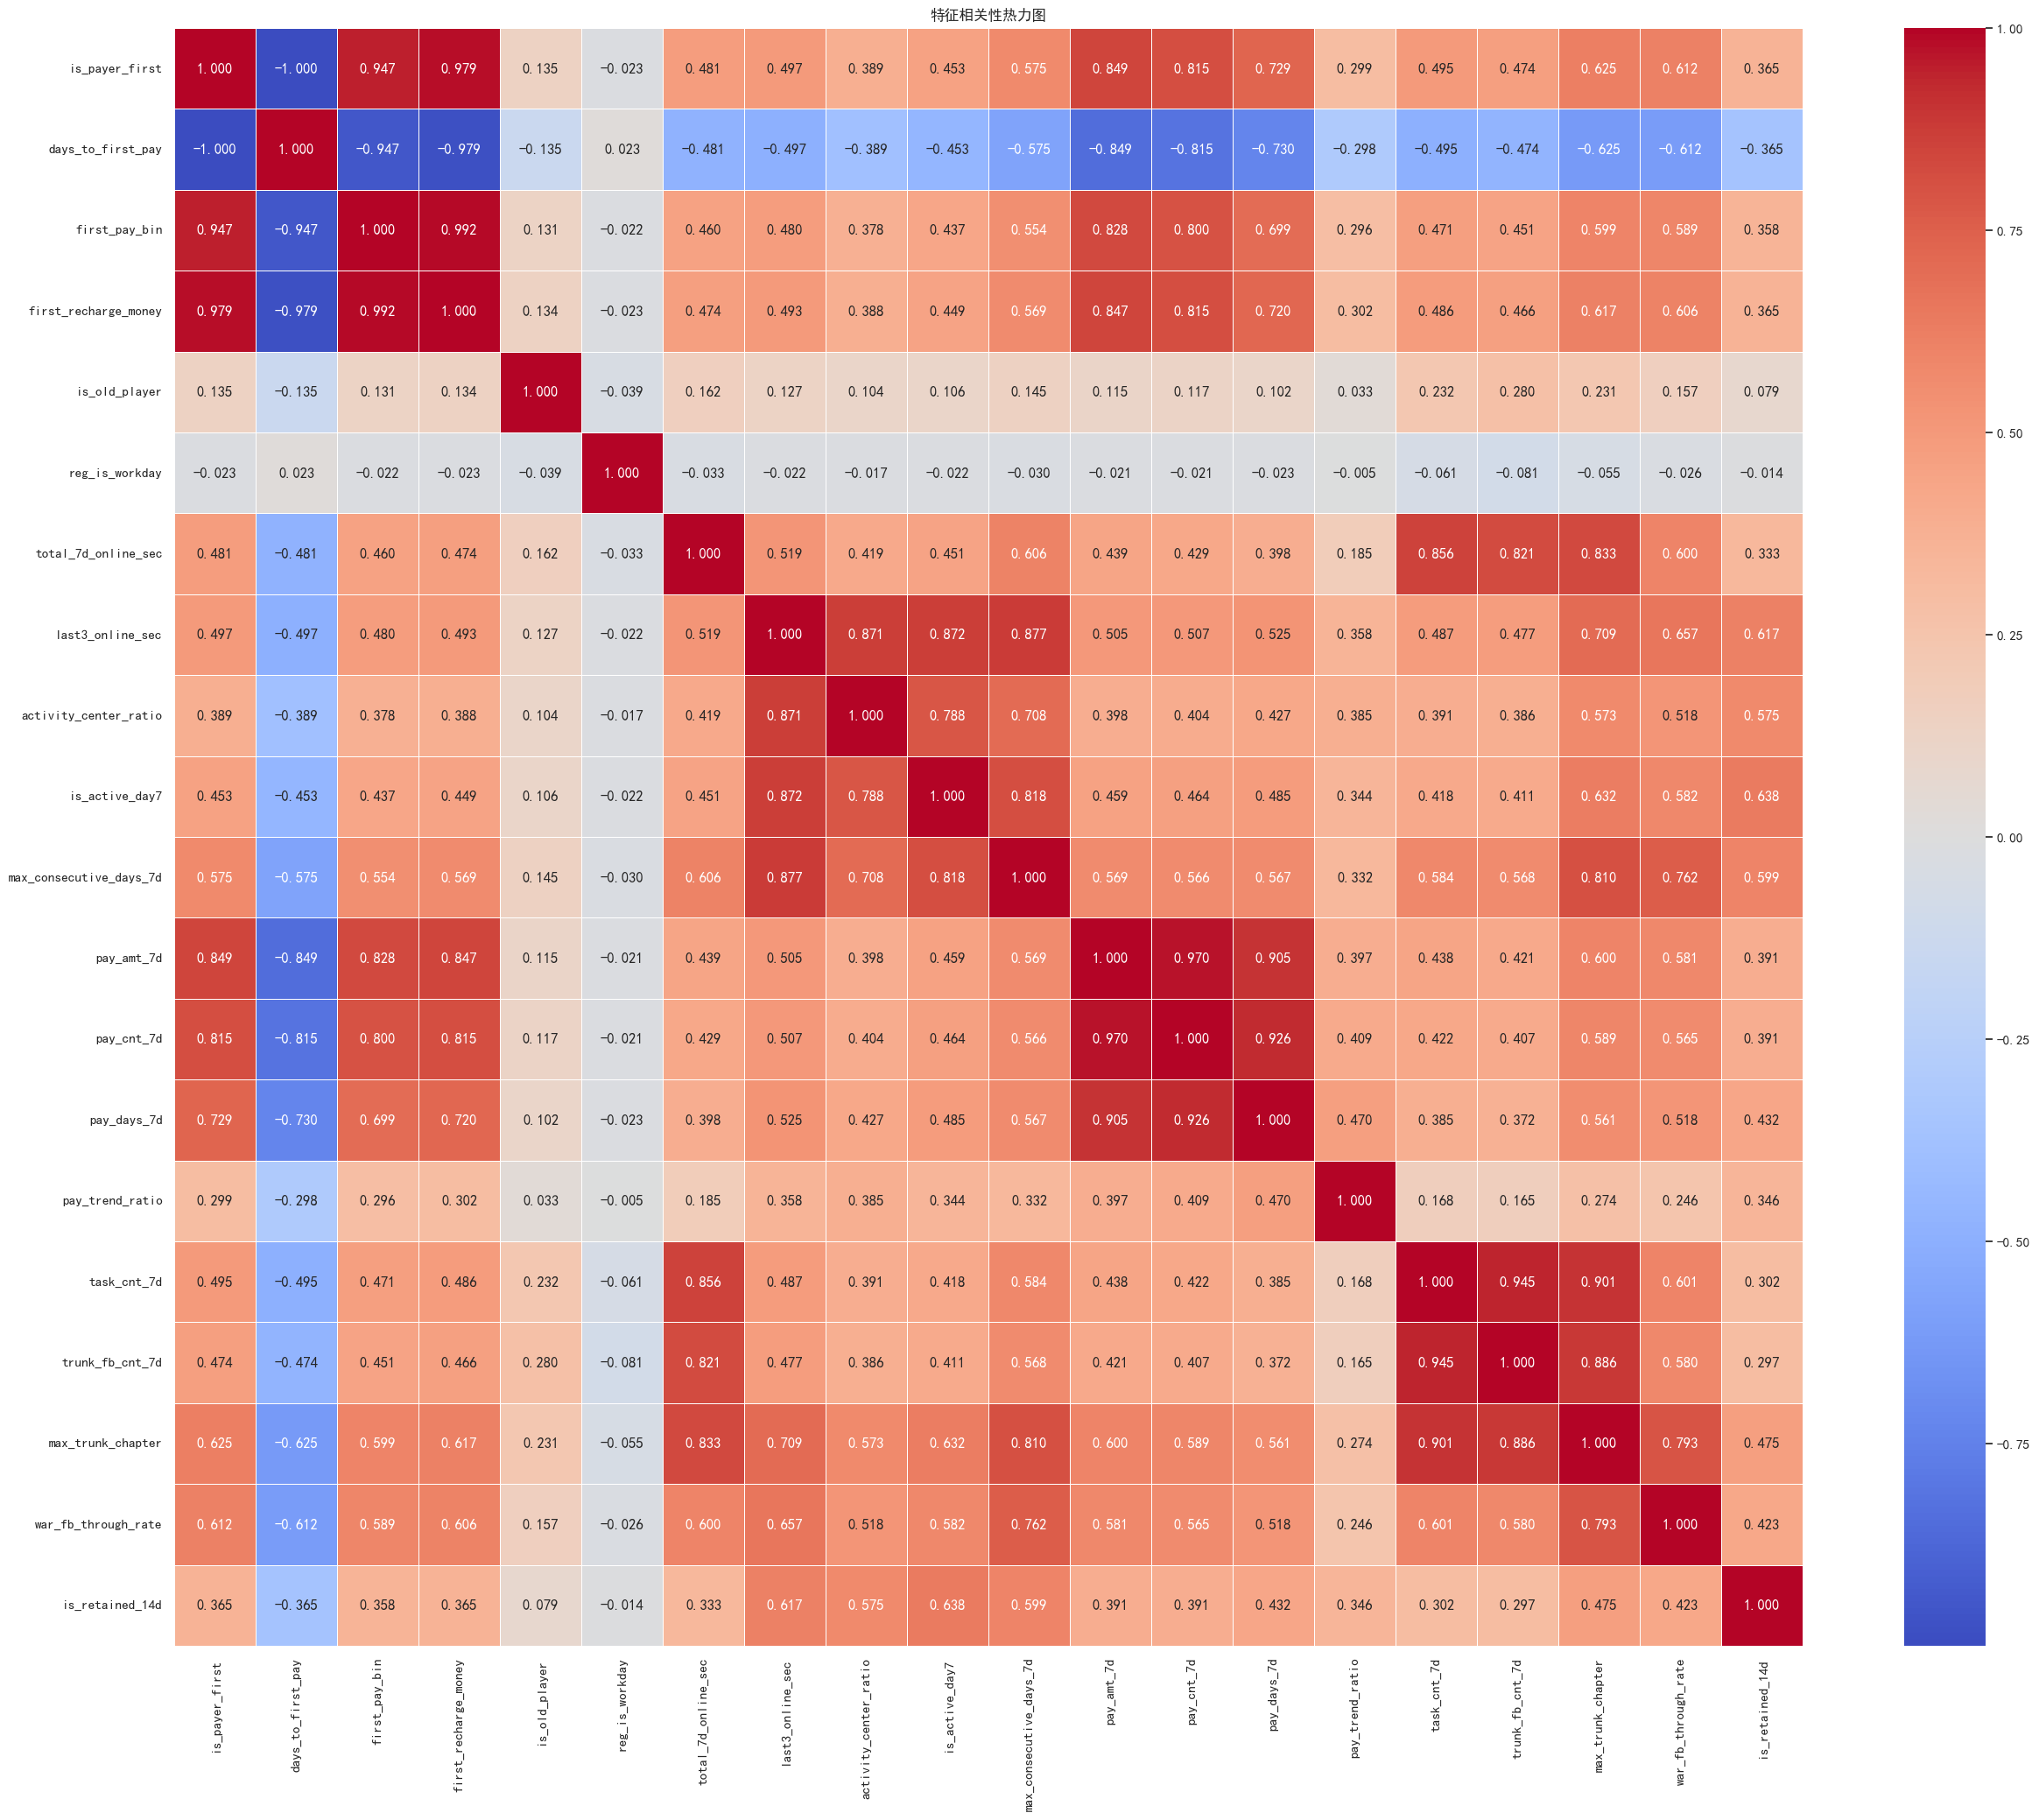

,is_payer_first,days_to_first_pay,first_pay_bin,first_recharge_money,is_old_player,reg_is_workday,total_7d_online_sec,last3_online_sec,activity_center_ratio,is_active_day7,max_consecutive_days_7d,pay_amt_7d,pay_cnt_7d,pay_days_7d,pay_trend_ratio,task_cnt_7d,trunk_fb_cnt_7d,max_trunk_chapter,war_fb_through_rate,is_retained_14d
is_payer_first,1.000000,-1.000000,0.947374,0.979128,0.134809,-0.022698,0.480839,0.497156,0.389326,0.453452,0.574764,0.849111,0.814682,0.729494,0.298508,0.495002,0.474072,0.624662,0.612442,0.364678
days_to_first_pay,-1.000000,1.000000,-0.947363,-0.979121,-0.134817,0.022697,-0.480832,-0.497107,-0.389263,-0.453398,-0.574726,-0.849182,-0.814751,-0.729556,-0.298485,-0.495001,-0.474070,-0.624652,-0.612436,-0.364597
first_pay_bin,0.947374,-0.947363,1.000000,0.991574,0.131152,-0.022424,0.460015,0.479630,0.377912,0.436620,0.553645,0.828176,0.799580,0.699278,0.295701,0.470999,0.451477,0.599400,0.588980,0.357683
first_recharge_money,0.979128,-0.979121,0.991574,1.000000,0.134210,-0.023158,0.473865,0.492770,0.387621,0.448857,0.569015,0.847023,0.815297,0.719934,0.301649,0.486047,0.465761,0.616823,0.605812,0.365322
is_old_player,0.134809,-0.134817,0.131152,0.134210,1.000000,-0.039464,0.162016,0.127196,0.103550,0.106069,0.144513,0.114537,0.117378,0.101865,0.032752,0.232136,0.279741,0.231219,0.157397,0.078563
reg_is_workday,-0.022698,0.022697,-0.022424,-0.023158,-0.039464,1.000000,-0.033050,-0.022483,-0.016766,-0.022133,-0.029631,-0.021278,-0.020521,-0.022515,-0.005120,-0.060707,-0.080991,-0.054593,-0.025960,-0.014391
total_7d_online_sec,0.480839,-0.480832,0.460015,0.473865,0.162016,-0.033050,1.000000,0.519391,0.418671,0.450799,0.605989,0.439058,0.428941,0.398021,0.185325,0.855979,0.821483,0.832857,0.600242,0.333168
last3_online_sec,0.497156,-0.497107,0.479630,0.492770,0.127196,-0.022483,0.519391,1.000000,0.871243,0.872129,0.877494,0.505289,0.507367,0.525211,0.357858,0.486889,0.477103,0.709245,0.657359,0.616601
activity_center_ratio,0.389326,-0.389263,0.377912,0.387621,0.103550,-0.016766,0.418671,0.871243,1.000000,0.787679,0.707860,0.398193,0.404233,0.427222,0.384760,0.390802,0.386381,0.572726,0.518125,0.575391
is_active_day7,0.453452,-0.453398,0.436620,0.448857,0.106069,-0.022133,0.450799,0.872129,0.787679,1.000000,0.818000,0.458853,0.464363,0.484931,0.344373,0.417870,0.410539,0.632175,0.582070,0.637813


In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 24))
sns.heatmap(
    df_model.corr(numeric_only=True), 
    annot=True,          # 显示数字
    fmt=".3f",           # 保留3位小数
    cmap="coolwarm",     # 颜色风格（红正蓝负）
    linewidths=0.5
)
plt.title("特征相关性热力图")
plt.show()
df_model.select_dtypes(include=['number', 'float', 'int']).corr()

AUC: 0.9629
Accuracy: 0.9874
F1: 0.6308


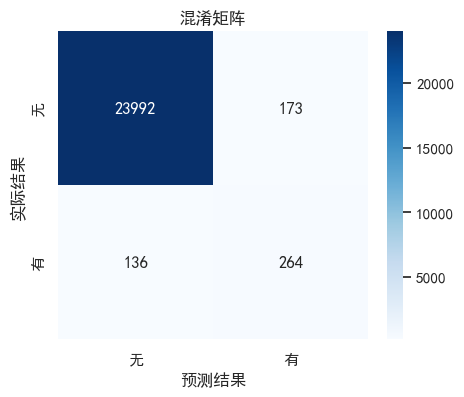


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     24165
           1       0.60      0.66      0.63       400

    accuracy                           0.99     24565
   macro avg       0.80      0.83      0.81     24565
weighted avg       0.99      0.99      0.99     24565



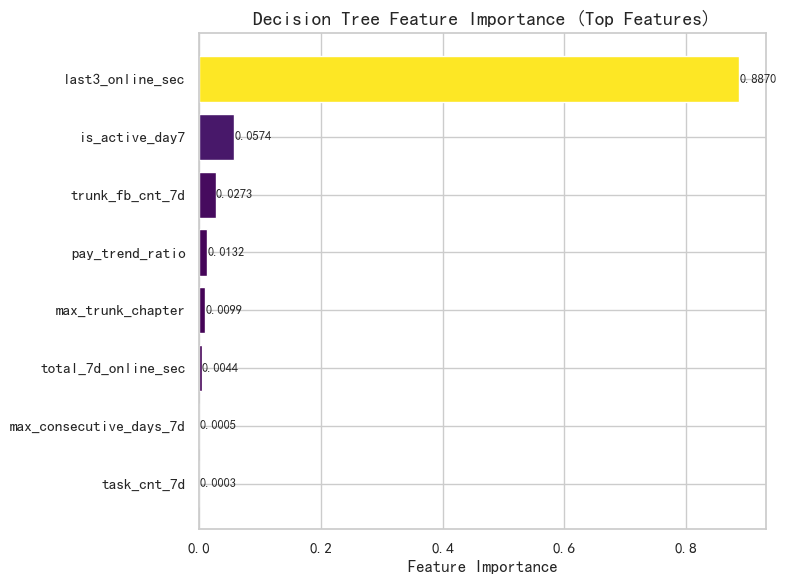


=== 特征重要性排名 ===
                feature  importance
       last3_online_sec    0.887041
         is_active_day7    0.057413
        trunk_fb_cnt_7d    0.027293
        pay_trend_ratio    0.013221
      max_trunk_chapter    0.009909
    total_7d_online_sec    0.004410
max_consecutive_days_7d    0.000458
            task_cnt_7d    0.000255


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )
df_model = df_model.copy()

# ===================== 核心修改：适配2024/1/7格式的日期转换 =====================
# 将char类型的first_login_date转换为datetime（匹配2024/1/7格式）
df_model['first_login_date'] = pd.to_datetime(
    df['first_login_date'],
    format='%Y/%m/%d',  # 精准匹配 年/月/日 格式（支持月份无前置零）
    errors='coerce'     # 转换失败的日期设为NaT，避免报错
)

# 设定切分点并转换为datetime类型（统一格式后再比较）
split_date = pd.to_datetime('2024-01-16')

# 数据校验：过滤转换失败的样本，避免空集
df_model_valid = df_model.dropna(subset=['first_login_date'])
if len(df_model_valid) == 0:
    raise ValueError("所有first_login_date转换失败，请检查日期格式是否为2024/1/7！")

# 筛选训练/测试集（此时日期比较准确）
train_df = df_model_valid[df_model_valid['first_login_date'] < split_date]
test_df  = df_model_valid[df_model_valid['first_login_date'] >= split_date]

# 容错处理：若训练/测试集为空，自动调整切分点
if len(train_df) == 0:
    split_date = df_model_valid['first_login_date'].median()
    print(f"⚠️  原切分点无训练样本，自动调整为: {split_date.date()}")
    train_df = df_model_valid[df_model_valid['first_login_date'] < split_date]
    test_df  = df_model_valid[df_model_valid['first_login_date'] >= split_date]

if len(test_df) == 0:
    raise ValueError("测试集样本数为0，请调整split_date或检查数据范围！")

# ===================== 原有逻辑保留 =====================
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# 训练决策树
clf = DecisionTreeClassifier(
    max_depth=4, 
    min_samples_leaf=10,
    random_state=42
)
clf.fit(X_train, y_train)

# 预测
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# 评估
auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print("AUC:", round(auc, 4))
print("Accuracy:", round(acc, 4))
print("F1:", round(f1, 4))

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['无', '有'],
            yticklabels=['无', '有'])
plt.title('混淆矩阵')
plt.xlabel('预测结果')
plt.ylabel('实际结果')
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 特征重要性分析
importance_df = pd.DataFrame({
    'feature': features,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

# 只显示重要性 > 0 的特征
importance_df = importance_df[importance_df['importance'] > 0].head(15)  # 最多显示15个

# 绘制水平条形图
plt.figure(figsize=(8, 6))
bars = plt.barh(
    range(len(importance_df)), 
    importance_df['importance'],
    color=plt.cm.viridis(importance_df['importance'] / importance_df['importance'].max())
)

# 添加数值标签
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(
        width + 0.0005,  # x位置（略右移避免重叠）
        bar.get_y() + bar.get_height()/2,  # y位置（垂直居中）
        f'{width:.4f}',  # 显示4位小数
        ha='left', 
        va='center',
        fontsize=9
    )

# 设置坐标轴
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance (Top Features)', fontsize=14)
plt.gca().invert_yaxis()  # 最重要的特征在顶部
plt.tight_layout()
plt.show()

# 打印文本版重要性（方便复制）
print("\n=== 特征重要性排名 ===")
print(importance_df.to_string(index=False))

Baseline AUC: 0.9808
Baseline Accuracy: 0.9881
Baseline F1: 0.6158
Confusion Matrix:
 [[24039   126]
 [  166   234]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     24165
           1       0.65      0.58      0.62       400

    accuracy                           0.99     24565
   macro avg       0.82      0.79      0.80     24565
weighted avg       0.99      0.99      0.99     24565



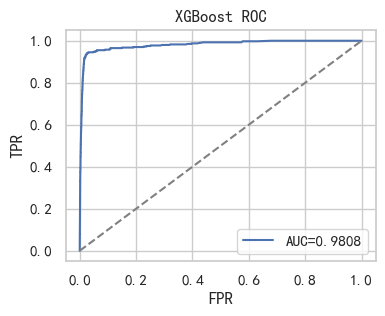

CV AUC Mean: 0.9831737472580319 Std: 0.0029524474055369096
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 1.0}
Best CV AUC: 0.9853342275382737
Best AUC: 0.9816
Best Accuracy: 0.9876
Best F1: 0.6013


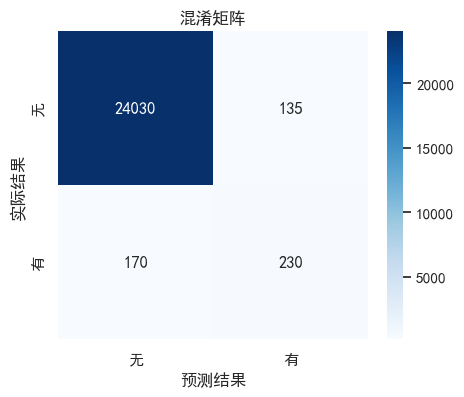


Feature Importance Ranking:
                    feature  importance
9            is_active_day7    0.577913
7          last3_online_sec    0.164862
10  max_consecutive_days_7d    0.128263
17        max_trunk_chapter    0.017829
8     activity_center_ratio    0.015333
0            is_payer_first    0.013087
6       total_7d_online_sec    0.012849
16          trunk_fb_cnt_7d    0.010720
1         days_to_first_pay    0.010495
14          pay_trend_ratio    0.008308
11               pay_amt_7d    0.006964
18      war_fb_through_rate    0.006222
15              task_cnt_7d    0.005977
13              pay_days_7d    0.005242
4             is_old_player    0.005232
12               pay_cnt_7d    0.004665
5            reg_is_workday    0.003932
3      first_recharge_money    0.002106
2             first_pay_bin    0.000000


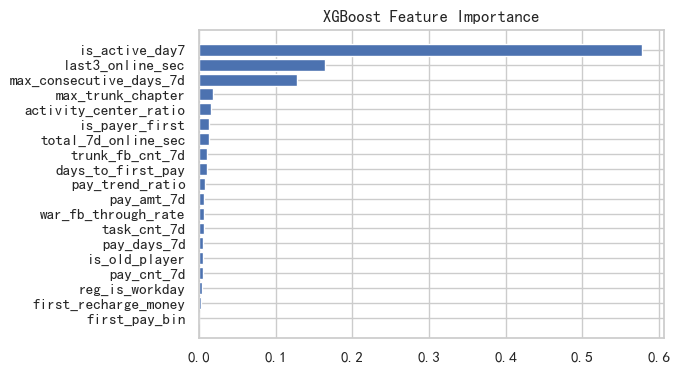

Baseline -> AUC: 0.9808 ACC: 0.9881 F1: 0.6158
Best     -> AUC: 0.9816 ACC: 0.9876 F1: 0.6013


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve

# # 准备数据
# df_model = df_model.copy()
# df_model['first_login_date'] = df['first_login_date']  # 用原表日期做切分

# # 设定切分点（可调整）
# split_date = '2024-01-16'

# train_df = df_model[df_model['first_login_date'] < split_date]
# test_df  = df_model[df_model['first_login_date'] >= split_date]

# X_train = train_df[features]
# y_train = train_df[target]

# X_test = test_df[features]
# y_test = test_df[target]

# 2) 基线模型
base_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)
base_clf.fit(X_train, y_train)

y_pred = base_clf.predict(X_test)
y_proba = base_clf.predict_proba(X_test)[:, 1]

# 评估
auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print("Baseline AUC:", round(auc, 4))
print("Baseline Accuracy:", round(acc, 4))
print("Baseline F1:", round(f1, 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("XGBoost ROC"); plt.legend()
plt.show()

# 3) 交叉验证（AUC）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(base_clf, X, y, cv=cv, scoring='roc_auc')
print("CV AUC Mean:", cv_auc.mean(), "Std:", cv_auc.std())

# 4) 网格搜索调参
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric="auc", random_state=42),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best_clf = grid.best_estimator_

# 用最优模型评估
y_pred_best = best_clf.predict(X_test)
y_proba_best = best_clf.predict_proba(X_test)[:, 1]

auc_best = roc_auc_score(y_test, y_proba_best)
acc_best = accuracy_score(y_test, y_pred_best)
f1_best  = f1_score(y_test, y_pred_best)

print("Best AUC:", round(auc_best, 4))
print("Best Accuracy:", round(acc_best, 4))
print("Best F1:", round(f1_best, 4))

# 混淆矩阵可视化
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['无', '有'],
            yticklabels=['无', '有'])
plt.title('混淆矩阵')
plt.xlabel('预测结果')
plt.ylabel('实际结果')
plt.show()

# 特征重要性
importance = pd.DataFrame({
    'feature': features,
    'importance': best_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance)

plt.figure(figsize=(6,4))
plt.barh(importance['feature'], importance['importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance')
plt.show()
base_auc = roc_auc_score(y_test, y_proba)
base_acc = accuracy_score(y_test, y_pred)
base_f1  = f1_score(y_test, y_pred)

# 最优模型指标
best_auc = roc_auc_score(y_test, y_proba_best)
best_acc = accuracy_score(y_test, y_pred_best)
best_f1  = f1_score(y_test, y_pred_best)

print("Baseline -> AUC:", round(base_auc,4), "ACC:", round(base_acc,4), "F1:", round(base_f1,4))
print("Best     -> AUC:", round(best_auc,4), "ACC:", round(best_acc,4), "F1:", round(best_f1,4))


正负样本比例: 1075:62014 → scale_pos_weight = 57.69

Baseline Model Evaluation:
----------------------------------------
AUC-ROC: 0.9795
AUC-PR : 0.6124
Accuracy: 0.9766
F1-Score: 0.5627

Confusion Matrix:
[[23620   545]
 [   30   370]]

Classification Report:
              precision    recall  f1-score   support

Not Retained       1.00      0.98      0.99     24165
    Retained       0.40      0.93      0.56       400

    accuracy                           0.98     24565
   macro avg       0.70      0.95      0.78     24565
weighted avg       0.99      0.98      0.98     24565



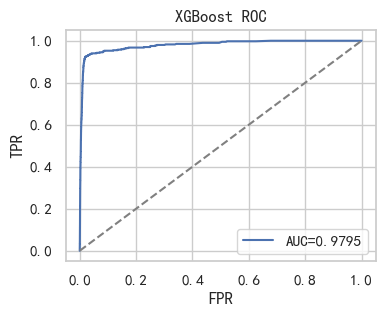

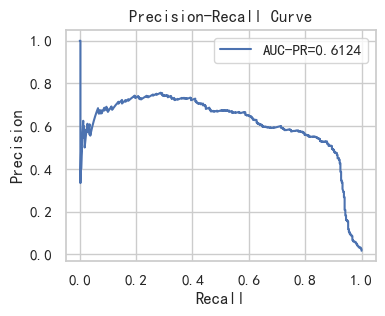


CV AUC Mean: 0.9818, Std: 0.0031
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': np.float64(57.687441860465114), 'subsample': 0.8}
Best CV AUC: 0.9834923829525479

Optimized Model Evaluation:
----------------------------------------
AUC-ROC: 0.9807
AUC-PR : 0.6312
Accuracy: 0.9721
F1-Score: 0.5193

Confusion Matrix:
[[23510   655]
 [   30   370]]

Classification Report:
              precision    recall  f1-score   support

Not Retained       1.00      0.97      0.99     24165
    Retained       0.36      0.93      0.52       400

    accuracy                           0.97     24565
   macro avg       0.68      0.95      0.75     24565
weighted avg       0.99      0.97      0.98     24565



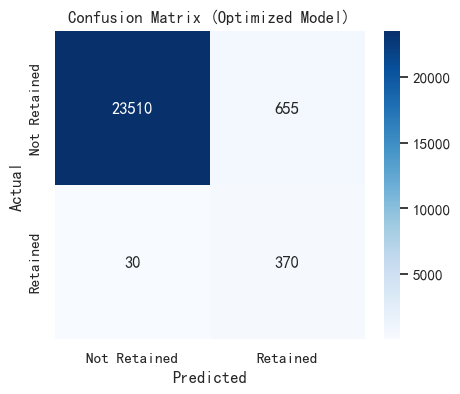


Feature Importance Ranking:
                    feature  importance
7          last3_online_sec    0.660020
10  max_consecutive_days_7d    0.079005
8     activity_center_ratio    0.078164
9            is_active_day7    0.048591
15              task_cnt_7d    0.015944
0            is_payer_first    0.015296
6       total_7d_online_sec    0.015213
1         days_to_first_pay    0.014544
16          trunk_fb_cnt_7d    0.013405
17        max_trunk_chapter    0.010913
5            reg_is_workday    0.009579
2             first_pay_bin    0.007973
4             is_old_player    0.007525
18      war_fb_through_rate    0.007500
11               pay_amt_7d    0.004953
13              pay_days_7d    0.004094
14          pay_trend_ratio    0.003738
12               pay_cnt_7d    0.003542
3      first_recharge_money    0.000000


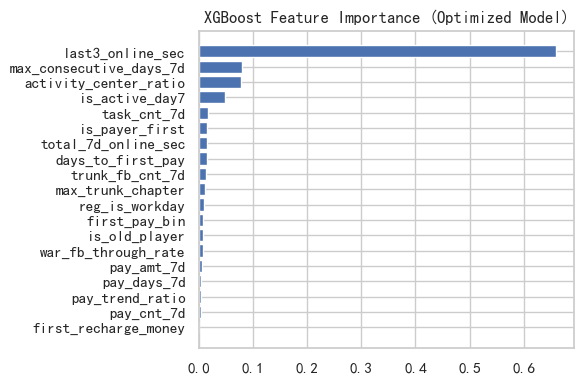


FINAL COMPARISON
Baseline -> AUC: 0.9795, PR-AUC: 0.6124, F1: 0.5627
Best     -> AUC: 0.9807, PR-AUC: 0.6312, F1: 0.5193


In [7]:

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    f1_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve,
    precision_recall_curve,  # 新增：用于PR曲线
    average_precision_score   # 新增：PR-AUC
)

# 准备数据
# X = df_model[features]
# y = df_model[target]

# 计算正负样本比例（用于scale_pos_weight）
neg_count = (y == 0).sum()
pos_count = (y == 1).sum()
scale_weight = neg_count / pos_count
print(f"正负样本比例: {pos_count}:{neg_count} → scale_pos_weight = {scale_weight:.2f}")

# # 1) 随机切分 80/20
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# 2) 基线模型（添加scale_pos_weight）
base_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_weight,  # 关键改进！
    eval_metric="auc",
    random_state=42
)
base_clf.fit(X_train, y_train)

y_pred = base_clf.predict(X_test)
y_proba = base_clf.predict_proba(X_test)[:, 1]

# 评估基线模型
def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)  # 新增PR-AUC
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{model_name} Evaluation:")
    print("-" * 40)
    print(f"AUC-ROC: {auc:.4f}")
    print(f"AUC-PR : {pr_auc:.4f}")  # 更关注这个！
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Not Retained', 'Retained']))
    
    return auc, pr_auc, acc, f1

# 评估基线模型
base_metrics = evaluate_model(y_test, y_pred, y_proba, "Baseline Model")

# ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f"AUC={base_metrics[0]:.4f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("XGBoost ROC"); plt.legend()
plt.show()

# PR 曲线（更适合不平衡数据）
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(4,3))
plt.plot(recall, precision, label=f"AUC-PR={base_metrics[1]:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 3) 交叉验证（AUC）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(base_clf, X, y, cv=cv, scoring='roc_auc')
print(f"\nCV AUC Mean: {cv_auc.mean():.4f}, Std: {cv_auc.std():.4f}")

# 4) 网格搜索调参（包含scale_pos_weight）
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "scale_pos_weight": [scale_weight]  # 固定使用计算出的权重
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric="auc", random_state=42),
    param_grid=param_grid,
    scoring="roc_auc",  # 也可尝试 "average_precision"（PR-AUC）
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("\nBest Params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best_clf = grid.best_estimator_

# 用最优模型评估
y_pred_best = best_clf.predict(X_test)
y_proba_best = best_clf.predict_proba(X_test)[:, 1]

# 评估最优模型
best_metrics = evaluate_model(y_test, y_pred_best, y_proba_best, "Optimized Model")

# 混淆矩阵可视化
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Retained', 'Retained'],
            yticklabels=['Not Retained', 'Retained'])
plt.title('Confusion Matrix (Optimized Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 特征重要性
importance = pd.DataFrame({
    'feature': features,
    'importance': best_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance)

plt.figure(figsize=(6,4))
plt.barh(importance['feature'], importance['importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance (Optimized Model)')
plt.tight_layout()
plt.show()

# 最终对比
print("\n" + "="*50)
print("FINAL COMPARISON")
print("="*50)
print(f"Baseline -> AUC: {base_metrics[0]:.4f}, PR-AUC: {base_metrics[1]:.4f}, F1: {base_metrics[3]:.4f}")
print(f"Best     -> AUC: {best_metrics[0]:.4f}, PR-AUC: {best_metrics[1]:.4f}, F1: {best_metrics[3]:.4f}")

训练集正负样本比例: 675:37849 → scale_pos_weight = 56.07
1. 训练单决策树模型（基线对比）

单决策树模型 核心评估指标:
--------------------------------------------------
整体准确率: 0.9874
留存用户精确率: 0.6041
留存用户召回率: 0.6600
F1值: 0.6308
AUC: 0.8264

混淆矩阵:
[[23992   173]
 [  136   264]]

分类报告:
              precision    recall  f1-score   support

         未留存       0.99      0.99      0.99     24165
          留存       0.60      0.66      0.63       400

    accuracy                           0.99     24565
   macro avg       0.80      0.83      0.81     24565
weighted avg       0.99      0.99      0.99     24565


2. 训练基础XGBoost模型（无不平衡参数）

基础XGBoost（无scale_pos_weight） 核心评估指标:
--------------------------------------------------
整体准确率: 0.9881
留存用户精确率: 0.6500
留存用户召回率: 0.5850
F1值: 0.6158
AUC: 0.7899

混淆矩阵:
[[24039   126]
 [  166   234]]

分类报告:
              precision    recall  f1-score   support

         未留存       0.99      0.99      0.99     24165
          留存       0.65      0.58      0.62       400

    accuracy                   

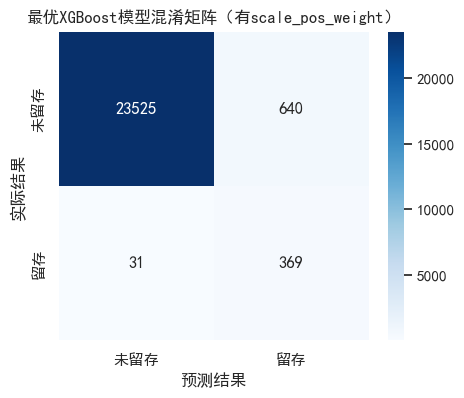


7. XGBoost特征重要性排名
                    feature  importance
7          last3_online_sec    0.505765
8     activity_center_ratio    0.201196
9            is_active_day7    0.082369
10  max_consecutive_days_7d    0.064387
16          trunk_fb_cnt_7d    0.033002
17        max_trunk_chapter    0.014589
6       total_7d_online_sec    0.013695
1         days_to_first_pay    0.012607
0            is_payer_first    0.011828
15              task_cnt_7d    0.011037
5            reg_is_workday    0.008053
2             first_pay_bin    0.007357
4             is_old_player    0.007085
12               pay_cnt_7d    0.006567
18      war_fb_through_rate    0.005379
11               pay_amt_7d    0.004711
3      first_recharge_money    0.003920
14          pay_trend_ratio    0.003858
13              pay_days_7d    0.002595


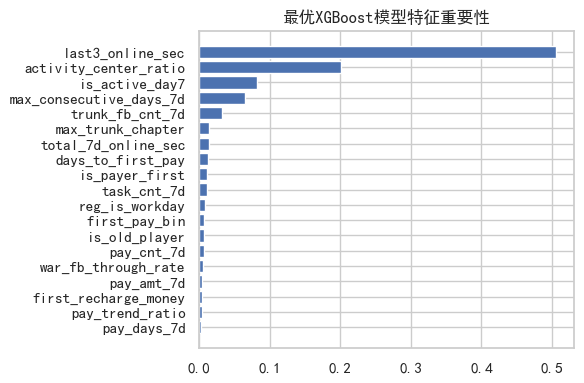


FINAL COMPARISON | scale_pos_weight 对召回率/准确率的影响
     指标   单决策树  XGBoost（无weight）  XGBoost（有weight）  XGBoost（最优）
  整体准确率 0.9874            0.9881            0.9766       0.9727
留存用户精确率 0.6041            0.6500            0.4039       0.3657
留存用户召回率 0.6600            0.5850            0.9250       0.9225
    F1值 0.6308            0.6158            0.5623       0.5238
    AUC 0.8264            0.7899            0.9512       0.9480


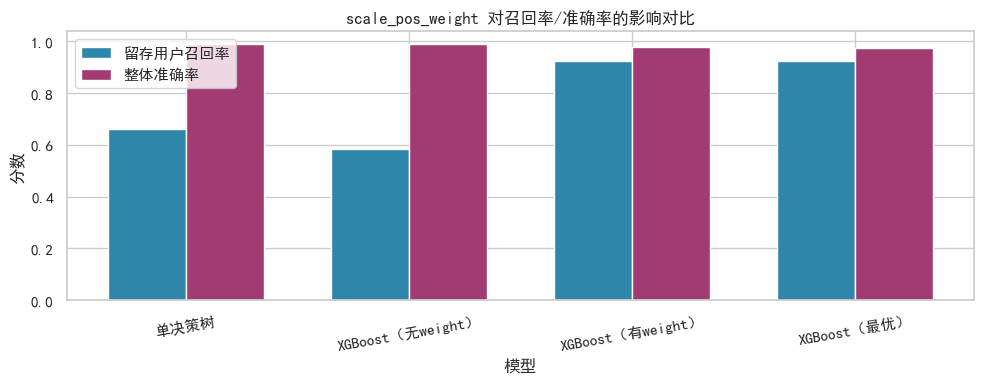

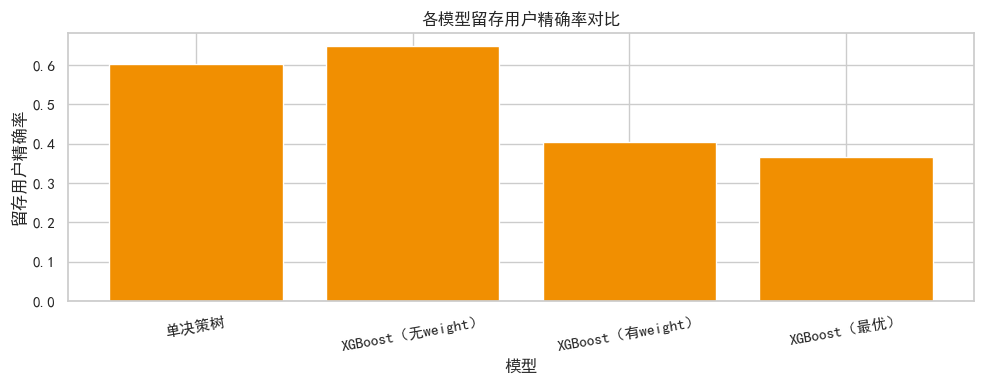

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    f1_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve,
    precision_score,
    recall_score
)

# ===================== 1. 数据准备（适配2024/1/7日期格式） =====================
# 假设df_model/features/target已提前定义
df_model['first_login_date'] = pd.to_datetime(
    df_model['first_login_date'],
    format='%Y/%m/%d',
    errors='coerce'
)
split_date = pd.to_datetime('2024-01-16')
df_model_valid = df_model.dropna(subset=['first_login_date'])
train_df = df_model_valid[df_model_valid['first_login_date'] < split_date]
test_df  = df_model_valid[df_model_valid['first_login_date'] >= split_date]

# 容错处理：避免空训练/测试集
if len(train_df) == 0:
    split_date = df_model_valid['first_login_date'].median()
    train_df = df_model_valid[df_model_valid['first_login_date'] < split_date]
    test_df  = df_model_valid[df_model_valid['first_login_date'] >= split_date]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# 计算正负样本比例（用于scale_pos_weight）
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_weight = neg_count / pos_count
print(f"训练集正负样本比例: {pos_count}:{neg_count} → scale_pos_weight = {scale_weight:.2f}")

# ===================== 2. 统一评估函数（聚焦留存用户召回率/准确率） =====================
def evaluate_model(y_true, y_pred, model_name="Model"):
    """统一评估函数：重点输出留存用户的精确率、召回率"""
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)  # 留存用户精确率
    recall = recall_score(y_true, y_pred)        # 留存用户召回率（核心）
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    print(f"\n{model_name} 核心评估指标:")
    print("-" * 50)
    print(f"整体准确率: {acc:.4f}")
    print(f"留存用户精确率: {precision:.4f}")  # 预测留存中实际留存的比例
    print(f"留存用户召回率: {recall:.4f}")    # 实际留存中被预测到的比例（核心）
    print(f"F1值: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\n混淆矩阵:")
    print(confusion_matrix(y_true, y_pred))
    print("\n分类报告:")
    print(classification_report(y_true, y_pred, target_names=['未留存', '留存']))
    
    # 返回核心指标（方便后续对比）
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# ===================== 3. 基线模型1：单决策树（原参数） =====================
print("="*60)
print("1. 训练单决策树模型（基线对比）")
print("="*60)
dt_clf = DecisionTreeClassifier(
    max_depth=4, 
    min_samples_leaf=10,
    random_state=42
)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
dt_metrics = evaluate_model(y_test, dt_pred, "单决策树模型")

# ===================== 4. 基线模型2：基础XGBoost（无scale_pos_weight） =====================
print("\n" + "="*60)
print("2. 训练基础XGBoost模型（无不平衡参数）")
print("="*60)
xgb_base_no_weight = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    # 核心：不设置scale_pos_weight
    eval_metric="auc",
    random_state=42
)
xgb_base_no_weight.fit(X_train, y_train)
xgb_base_no_weight_pred = xgb_base_no_weight.predict(X_test)
xgb_base_no_weight_metrics = evaluate_model(y_test, xgb_base_no_weight_pred, "基础XGBoost（无scale_pos_weight）")

# ===================== 5. 基线模型3：XGBoost（有scale_pos_weight） =====================
print("\n" + "="*60)
print("3. 训练XGBoost模型（有不平衡参数）")
print("="*60)
xgb_base_with_weight = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_weight,  # 核心：添加不平衡参数
    eval_metric="auc",
    random_state=42
)
xgb_base_with_weight.fit(X_train, y_train)
xgb_base_with_weight_pred = xgb_base_with_weight.predict(X_test)
xgb_base_with_weight_metrics = evaluate_model(y_test, xgb_base_with_weight_pred, "XGBoost（有scale_pos_weight）")

# ===================== 6. XGBoost交叉验证（基于有weight的模型） =====================
print("\n" + "="*60)
print("4. XGBoost交叉验证（AUC）")
print("="*60)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(xgb_base_with_weight, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"5折交叉验证AUC均值: {cv_auc.mean():.4f}, 标准差: {cv_auc.std():.4f}")

# ===================== 7. XGBoost网格搜索调参（含scale_pos_weight） =====================
print("\n" + "="*60)
print("5. XGBoost网格搜索调参")
print("="*60)
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "scale_pos_weight": [scale_weight]  # 固定不平衡参数
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric="auc", random_state=42),
    param_grid=param_grid,
    scoring="roc_auc",
    #scoring="recall",  # 改为优化召回率
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print(f"\n最优参数: {grid.best_params_}")
print(f"最优交叉验证AUC: {grid.best_score_:.4f}")

# ===================== 8. 最优XGBoost模型评估 =====================
print("\n" + "="*60)
print("6. 最优XGBoost模型评估（有scale_pos_weight）")
print("="*60)
xgb_best_clf = grid.best_estimator_
xgb_best_pred = xgb_best_clf.predict(X_test)
xgb_best_metrics = evaluate_model(y_test, xgb_best_pred, "最优XGBoost模型（有scale_pos_weight）")

# ===================== 9. 混淆矩阵可视化（最优XGBoost） =====================
conf_matrix = confusion_matrix(y_test, xgb_best_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['未留存', '留存'],
            yticklabels=['未留存', '留存'])
plt.title('最优XGBoost模型混淆矩阵（有scale_pos_weight）')
plt.xlabel('预测结果')
plt.ylabel('实际结果')
plt.show()

# ===================== 10. 特征重要性（最优XGBoost） =====================
importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_best_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("7. XGBoost特征重要性排名")
print("="*60)
print(importance)

plt.figure(figsize=(6,4))
plt.barh(importance['feature'], importance['importance'])
plt.gca().invert_yaxis()
plt.title('最优XGBoost模型特征重要性')
plt.tight_layout()
plt.show()

# ===================== 11. 最终对比（四层模型） =====================
print("\n" + "="*60)
print("FINAL COMPARISON | scale_pos_weight 对召回率/准确率的影响")
print("="*60)
comparison_df = pd.DataFrame({
    '指标': ['整体准确率', '留存用户精确率', '留存用户召回率', 'F1值', 'AUC'],
    '单决策树': [
        dt_metrics['accuracy'],
        dt_metrics['precision'],
        dt_metrics['recall'],
        dt_metrics['f1'],
        dt_metrics['auc']
    ],
    'XGBoost（无weight）': [
        xgb_base_no_weight_metrics['accuracy'],
        xgb_base_no_weight_metrics['precision'],
        xgb_base_no_weight_metrics['recall'],
        xgb_base_no_weight_metrics['f1'],
        xgb_base_no_weight_metrics['auc']
    ],
    'XGBoost（有weight）': [
        xgb_base_with_weight_metrics['accuracy'],
        xgb_base_with_weight_metrics['precision'],
        xgb_base_with_weight_metrics['recall'],
        xgb_base_with_weight_metrics['f1'],
        xgb_base_with_weight_metrics['auc']
    ],
    'XGBoost（最优）': [
        xgb_best_metrics['accuracy'],
        xgb_best_metrics['precision'],
        xgb_best_metrics['recall'],
        xgb_best_metrics['f1'],
        xgb_best_metrics['auc']
    ]
})
# 保留4位小数，方便对比
comparison_df = comparison_df.round(4)
print(comparison_df.to_string(index=False))

# ===================== 12. 可视化对比（核心：召回率/准确率） =====================
# 12.1 留存用户召回率对比
plt.figure(figsize=(10, 4))
models = ['单决策树', 'XGBoost（无weight）', 'XGBoost（有weight）', 'XGBoost（最优）']
recall_scores = [
    dt_metrics['recall'],
    xgb_base_no_weight_metrics['recall'],
    xgb_base_with_weight_metrics['recall'],
    xgb_best_metrics['recall']
]
accuracy_scores = [
    dt_metrics['accuracy'],
    xgb_base_no_weight_metrics['accuracy'],
    xgb_base_with_weight_metrics['accuracy'],
    xgb_best_metrics['accuracy']
]

x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, recall_scores, width, label='留存用户召回率', color='#2E86AB')
plt.bar(x + width/2, accuracy_scores, width, label='整体准确率', color='#A23B72')

plt.xlabel('模型')
plt.ylabel('分数')
plt.title('scale_pos_weight 对召回率/准确率的影响对比')
plt.xticks(x, models, rotation=10)
plt.legend()
plt.tight_layout()
plt.show()

# 12.2 留存用户精确率对比（补充）
plt.figure(figsize=(10, 4))
precision_scores = [
    dt_metrics['precision'],
    xgb_base_no_weight_metrics['precision'],
    xgb_base_with_weight_metrics['precision'],
    xgb_best_metrics['precision']
]
plt.bar(models, precision_scores, color='#F18F01')
plt.xlabel('模型')
plt.ylabel('留存用户精确率')
plt.title('各模型留存用户精确率对比')
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()